Example taken from Google ML Crash Course:
https://developers.google.com/machine-learning/crash-course/feature-crosses/encoding-nonlinearity

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf 

Create the sample data set

Scale and shift the (0, 1) range from np.random.random to (-5, 5).

See also here: https://stackoverflow.com/questions/59389241/how-to-generate-a-random-float-in-range-1-1-using-numpy-random-rand

In [23]:
N = 100
max_val, min_val = 5, -5
range_size = (max_val - min_val)  # 2
x = np.random.random([N]) * range_size + min_val
y = np.random.random([N]) * range_size + min_val

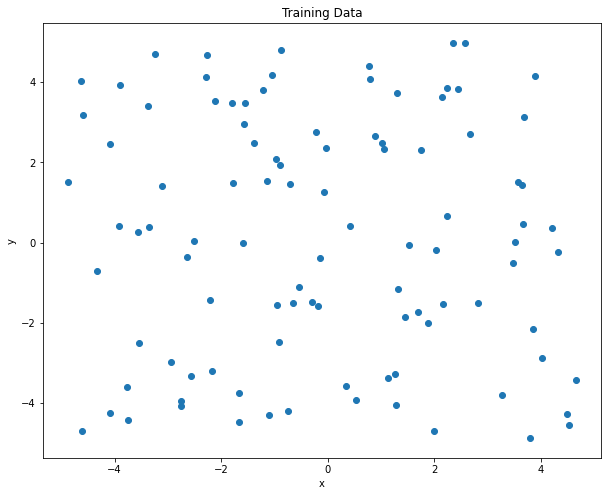

In [24]:
plt.figure(figsize=(10, 8))

plt.scatter(x, y)

plt.xlabel('x') 
plt.ylabel('y') 

plt.title("Training Data") 
plt.show() 